# DeepNeuralNetwork(Keras)

In [1]:
import h5py
import keras
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense,Input
import matplotlib.pyplot as plt
from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(2)   

Using TensorFlow backend.


### 1 Load Data

In [2]:
def load_data():
    '''
    create train set and test set
    make sure you have .h5 file in your dataset
    
    Returns:
    -------
        train_set_x_orig: original train set shape is (209, 64, 64, 3) 
        train_set_y_orig: original train label shape is (209,)
        test_set_x_orig: original test set shape is (50, 64, 64, 3)
        test_set_y_orig: original test label shape is (50,)
        classes: cat or non-cat.
        
    Note:
    ----
        (209, 64, 64, 3): 209 picture,64 width,64 height,3 channel.
    '''
    train_dataset = h5py.File('../data_set/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../data_set/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [4]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1) / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1) / 255
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(209, 12288)
Test_x's shape:(50, 12288)
Train_y's shape:(209, 1)
Test_y's shape:(50, 1)


### Sequential of DNN

使用Sequential构建DNN

(1) 同样我们可以使用xavier initial来初始化并设置随机数种子.

```python
keras.initializers.glorot_normal```

当然,也可以使用Densen默认的选项```glorot_uniform```进行初始化.

(2) 构建Input layer

```python
model.add(Dense(units=layers[0],input_shape=(n,),activation='relu',kernel_initializer=initial))```

(3) 使用循环的方式构建hidden layer

```python
for l in range(1,L-1):
    model.add(Dense(units=layers[l],activation='relu',kernel_initializer=initial))```
    
(4) 构建output layer

```python
model.add(Dense(units=layers[-1],activation='sigmoid',kernel_initializer=initial))```

**Ps:**

(1) input layer 和 hidden layer都是使用ReLu activate function.

(2) output layer 使用 sigmoid function

(3) loss function:binary cross entropy

(4) optimizer: SGD minibatch:32.

(5) 由于我们这里样本量较小,所以就不在fit中指定验证样本```validation_data```.

In [5]:
def DNN_keras(X,y,layers,alpha,Iter):
    """
    Using Keras to build DNN
    
    Parameters:
    ----------
        X: training data
        y: training labels
        layers: Model layers layers:hidden and output layers.
        alpha: learning rate.
        Iter: #Iteration 
    Return:
    ------
        model: best model,when this model fitting  okay.
    """
    m,n = X.shape
    L = len(layers)
    model = Sequential()
    initial = keras.initializers.glorot_normal(seed=3)
    model.add(Dense(units=layers[0],input_shape=(n,),activation='relu',kernel_initializer=initial))
    for l in range(1,L-1):
        model.add(Dense(units=layers[l],activation='relu',kernel_initializer=initial))
    model.add(Dense(units=layers[-1],activation='sigmoid',kernel_initializer=initial))

    SGD = keras.optimizers.SGD(lr=alpha)
    loss = keras.losses.binary_crossentropy
    model.compile(optimizer=SGD,loss=loss,metrics=['accuracy'])
    model.fit(x=X,y=y,epochs=Iter,verbose=0)

    return model

In [6]:
model = DNN_keras(train_x,train_y,[20,7,5,1],0.01,2000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


我们可以看看loss与accuracy的走势,这里取每10步绘制.

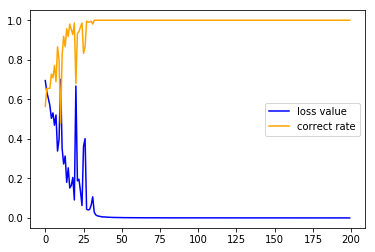

In [7]:
loss = model.history.history['loss']
costs = [loss[i] for i in range(len(loss)) if i%10==0]
acc = model.history.history['acc']
accuracy = [acc[i] for i in range(len(acc)) if i%10==0]
plt.plot(costs,c='blue',label='loss value')
plt.plot(accuracy,c='orange',label='correct rate')
plt.legend()
plt.show()

查看训练样本和测试样本的正确率

```python
model.evaluate```

In [8]:
loss,acc = model.evaluate(x=test_x,y=test_y)
print('The test data loss is {},acc is {}'.format(loss,acc))

50/50 [==============================] - 0s 752us/step
The test data loss is 3.052297763824463,acc is 0.7200000071525574


In [9]:
loss,acc = model.evaluate(x=train_x,y=train_y)
print('The test data loss is {},acc is {}'.format(loss,acc))

209/209 [==============================] - 0s 57us/step
The test data loss is 0.00010205139088529077,acc is 1.0


可以看到最终还是有点过拟合的意思,同样可以增加样本量,一种方法是将图片左右翻转,这样样本量就会增加一倍,这种处理方法在有时候是有效的.

### API of DNN

使用API的方式构建DNN

(1) 创建inputs layer

```python
inputs = Input((n,))```

(2) 使用Dense默认的初始化```glorot_uniform```并设置随机数种子.

```python
init = keras.initializers.glorot_uniform(seed=3)```

(3) 构建inputs layer

```python
Z = Dense(units=layers[0],activation='relu',kernel_initializer=init)(inputs)```

(4) 循环构建hidden layer

```python
for l in range(1,L-1):
    Z = Dense(units=layers[l],activation='relu',kernel_initializer=init)(Z)```
    
(5) 构建outputs layer

```python
predictions = Dense(units=layers[-1],activation='sigmoid',kernel_initializer=init)(Z)```

(6) 初始化模型输入为inputs,输出为outputs.

```python
model = Model(inputs=inputs, outputs=predictions)```

**Ps:**

(1) input layer 和 hidden layer都是使用ReLu activate function.

(2) output layer 使用 sigmoid function

(3) loss function:binary cross entropy

(4) optimizer: SGD.

In [10]:
def DNN_API(X,y,layers,alpha,Iter):
    """
    Using API to build DNN
    
    Parameters:
    ----------
        X: data set.
        y: true labels.
        layers: Model layers layers:hidden and output layers.
        alpha: learning rate.
        Iter: #iteration 
    Return:
    -------
        model: best model,when this model fitting  okay.
    """
    m,n = X.shape
    inputs = Input((n,))
    L = len(layers)
    init = keras.initializers.glorot_uniform(seed=3)
    Z = Dense(units=layers[0],activation='relu',kernel_initializer=init)(inputs)
    
    for l in range(1,L-1):
        Z = Dense(units=layers[l],activation='relu',kernel_initializer=init)(Z)
        
    predictions = Dense(units=layers[-1],activation='sigmoid',kernel_initializer=init)(Z)
    
    model = Model(inputs=inputs, outputs=predictions)
    optimizer = keras.optimizers.SGD(lr=alpha)
    loss = keras.losses.binary_crossentropy
    model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
    
    model.fit(x=X,y=y,epochs=Iter,verbose=0)
    
    return model

In [11]:
model = DNN_API(train_x,train_y,[20,7,5,1],0.01,2000)

查看一下model的整体结构```model.summary()```

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12288)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                245780    
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 147       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 245,973
Trainable params: 245,973
Non-trainable params: 0
_________________________________________________________________


可以看到我们有5层,分别是

(1): 输入层

(2): 4层常用全连接层

(3): 总体参数为245,973,能够训练的参数为245,973,不可训练的参数为0.

下面来测试一下正确率,很显然也会出现过拟合的现象.

In [13]:
loss,acc = model.evaluate(x=test_x,y=test_y)
print('test set loss:{},acc:{}'.format(loss,acc))

50/50 [==============================] - 0s 1ms/step
test set loss:1.7200681257247925,acc:0.7600000047683716


In [14]:
loss,acc = model.evaluate(x=train_x,y=train_y)
print('train set loss:{},acc:{}'.format(loss,acc))

209/209 [==============================] - 0s 96us/step
train set loss:0.0014674172482707284,acc:1.0


这里就不再测试另外的图片了,如果想测试自己的图片可以按照Application或者Tensorflow中的方法改变图片的大小并使用model.predictc测试

# Summary

实际上出现过拟合的现象是很正常的现象,最好的办法也就是增加样本集,或者调解optimizer和初始化方法.当然现在我们只是理解到简单的神经网络,后面我们会有相应的方法来减少过拟合或者欠拟合的发生.